### 1. Импортировать библиотеки в Python.

In [585]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import scipy
import torch

torch.cuda.synchronize()
torch.cuda.empty_cache()

cuda = torch.device('cuda')

### 2. Загрузка и подготовка данных.

In [586]:
name = random.choice(os.listdir("dataset"))

name = 'testLab1Var7.csv'

print(f"Dataset: {name}")

dataset = np.genfromtxt(f"dataset/{name}", delimiter=',')

dataset = [dataset[:, i] for i in range(dataset.shape[1])]
title = ["time", "current", "voltage"]

dataset_dict = dict(zip(title, dataset))

Dataset: testLab1Var7.csv


### 3. Нарисовать графики тока и напряжения.

Для удобства отображения отображу не весь график, а некоторый его случайный диапазон заданного размера, установив лимиты на данные.

In [587]:
"""
Размер интервала
"""
time_period = 0.1

In [588]:
time_interval = random.random() * (dataset_dict["time"][-1] - time_period)
time_interval = (time_interval, time_interval + time_period)

print(f"Временной интервал {time_interval}")

Временной интервал (45.93339540102384, 46.03339540102384)


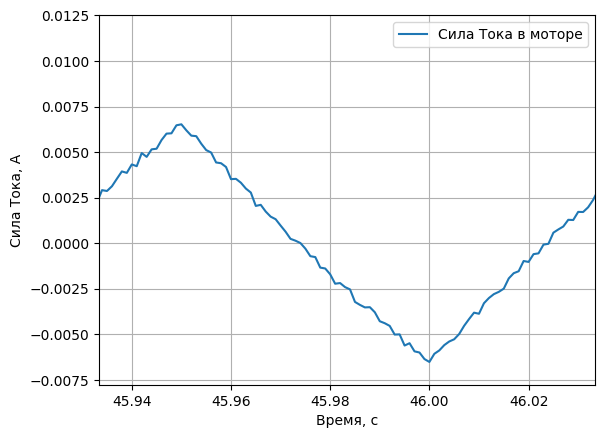

In [589]:
plt.plot(dataset_dict["time"], dataset_dict["current"])
plt.xlim(time_interval)
plt.xlabel('Время, с')
plt.ylabel('Сила Тока, А')
plt.legend(["Сила Тока в моторе"])
plt.grid()

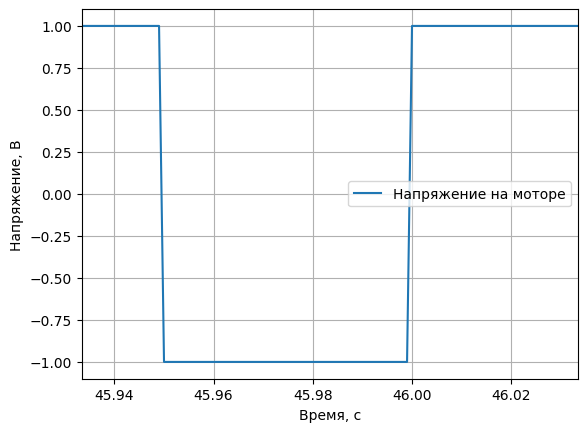

In [590]:
plt.plot(dataset_dict["time"], dataset_dict["voltage"])
plt.xlim(time_interval)
plt.xlabel('Время, с')
plt.ylabel('Напряжение, В')
plt.legend(["Напряжение на моторе"])
plt.grid()

### 4. Рассчитать значения параметров L и R.

[Упрощённая модель двигателя постоянного тока](https://life-prog.ru/2_22546_model-dvigatelya-postoyannogo-toka-s-nezavisimim-vozbuzhdeniem.html). Модель двигателя постоянного тока описывается следующей системой дифференциальных уравнений:

$$
\begin{cases}
u = e + R \times i + L \times \dfrac{di}{t}
\\
M - M_C = J \dfrac{d\omega}{t}
\\
M = C_{M} \times \Phi \times i
\\
e = C_{\omega} \times \Phi \times \omega
\end{cases}
$$

где

$u$ - напряжение на якорной обмотке двигателя,

$e$ - электродвижущая сила (ЭДС) якоря,

$i$ - ток якоря,

$\Phi$ - поток, создаваемый обмоткой возбуждения,

$M$ - электромагнитный момент двигателя,

$M_С$ - момент сопротивления движению,

$\omega$ - скорость вращения вала двигателя,

$R$ - активное сопротивление якорной цепи,

$L$ - индуктивность якорной цепи,

$J$ - суммарный момент инерции якоря и нагрузки,

$С_{\omega}$ - коэффициент связи между скоростью и ЭДС,

$С_М$ - коэффициент связи между током якоря и электромагнитным моментом.



Y = K*X

I(k) = (Ts / L) * U(k-1) - ((R*Ts - L) / L) * I(k-1)

I(k) = K1 * U(k-1) + K2 * I(k-1)



In [591]:
X = np.transpose(np.concatenate([np.array([dataset_dict["voltage"], ]), np.array([dataset_dict["current"], ])], axis=0))
Y = np.transpose(np.array([dataset_dict["current"], ]))

# X : n*k
# K : k*1
# X * K = Y
# [U(k-1);I(k-1)] * K = [I(k)]

X = X[:-1, :]  # U(k-1);I(k-1)
Y = Y[1:, :]  # I(k)

print(X.shape)
print(Y.shape)

X_tensor = torch.tensor(X, device=cuda, dtype=torch.float64)
Y_tensor = torch.tensor(Y, device=cuda, dtype=torch.float64)

(100000, 2)
(100000, 1)


Функция нахождения [псевдообратной матрицы Moore–Penrose](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) через Сингулярное Разложение.

Данная матрица позволяет аппроксимировать $Y = X \times K + e$ [Методом Наименьших Квадратов](https://www.gaussianwaves.com/2014/06/linear-models-least-squares-estimator-lse/amp/):

In [592]:
def get_pseudoinverse(matrix):
    matrix_svd = torch.svd(matrix)

    matrix_psi = matrix_svd.V
    matrix_psi = torch.mm(matrix_psi, torch.diag(1 / matrix_svd.S))
    matrix_psi = torch.mm(matrix_psi, matrix_svd.U.T)

    return matrix_psi

In [593]:
X_psi = get_pseudoinverse(X_tensor)

print(X_psi.shape)
print(X_tensor.shape)

torch.Size([2, 100000])
torch.Size([100000, 2])


Результатом перемножения псевдообратной матрицы от X и самой матрицы X должна быть матрица, близкая к единичной:

In [594]:
print(torch.mm(X_psi, X_tensor))

tensor([[ 1.0000e+00, -6.7233e-20],
        [-7.0222e-15,  1.0000e+00]], device='cuda:0', dtype=torch.float64)


$X \times K = Y \to K = X^{+} \times Y$, где $X^{+}$ - матрица, псевдообратная к X

In [595]:
K_approx = torch.mm(X_psi, Y_tensor)
print(K_approx)

tensor([[2.6420e-04],
        [9.9339e-01]], device='cuda:0', dtype=torch.float64)


Для нахождения ошибки между реальным значением $Y$ и его предсказанием моделью $X \times K$, можно просто посчитать их разность $e = Y - X \times K$

Тогда Сумма квадратов ошибки будет $S(K) = \sum_{}^{} e_{i}^{2} = e^{T} \times e = (Y - X \times K)^{T} \times (Y - X \times K)$

А среднеквадратичное отклонение $ \sigma = \sqrt{\dfrac{S(K)}{n}}$

In [596]:
e2_Y = torch.mm(Y_tensor.T - torch.mm(X_tensor, K_approx).T, Y_tensor - torch.mm(X_tensor, K_approx))
sigma2_Y = torch.divide(e2_Y, Y_tensor.shape[0])

sigma_Y = torch.sqrt(sigma2_Y)
sigma_Y = sigma_Y.cpu().numpy()[0][0]

print(sigma_Y)

0.00021120826770868625


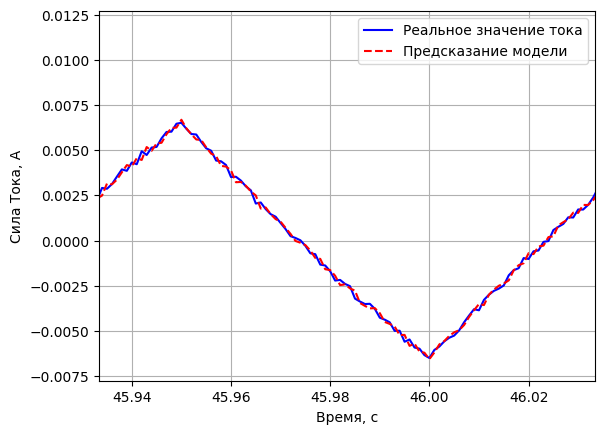

In [597]:
Y_predict = torch.mm(X_tensor, K_approx)
Y_predict = Y_predict.cpu().numpy()

# print(Y_predict.T[0].shape)
# print(dataset_dict["current"][1:].shape)

plt.plot(dataset_dict["time"][1:], dataset_dict["current"][1:], 'b')
plt.plot(dataset_dict["time"][1:], Y_predict.T[0], 'r--')
plt.xlim(time_interval)
plt.xlabel('Время, с')
plt.ylabel('Сила Тока, А')
plt.legend(["Реальное значение тока", "Предсказание модели"])
plt.grid()

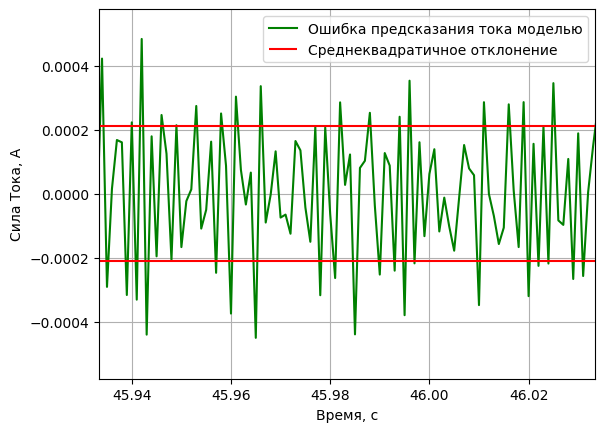

In [598]:
# print(Y_predict.T[0].shape)
# print(dataset_dict["current"][1:].shape)

plt.plot(dataset_dict["time"][1:], dataset_dict["current"][1:] - Y_predict.T[0], 'g')
plt.hlines([-sigma_Y, sigma_Y], dataset_dict["time"][0], dataset_dict["time"][-1], 'r')
plt.xlim(time_interval)
plt.xlabel('Время, с')
plt.ylabel('Сила Тока, А')
plt.legend(["Ошибка предсказания тока моделью", "Среднеквадратичное отклонение"])
plt.grid()

In [599]:
K = K_approx.cpu()

Td = 0.001
L = Td / K[0]
R = (L - K[1] * L) / Td

print('Вычисленное значение R = ', R.numpy()[0], ' Ом')
print('Вычисленное значение L = ', L.numpy()[0], ' Гн')

Вычисленное значение R =  25.027544616804676  Ом
Вычисленное значение L =  3.7850168932643307  Гн


In [628]:
R = 1 / K[0] * (1 - K[1])
T = -Td / np.log(K[1])
L = T * R

print('R = ', R.numpy()[0], ' Ohm')
print('L = ', L.numpy()[0], ' Hn')

R =  25.027544616804754  Ohm
L =  3.7724892844348483  Hn
